## Load data files
In this project, we will make use of the HDB (Housing Development Board) resale flats data to predict resale flat prices. 2 data files which consists of data from different year periods will be loaded into df and df_2 for analysis. 

In [1]:
import numpy as np
import pandas as pd
import os as os
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# file1 is from Mar 2012  - Dec 2014 while file2 is from Jan 2015 - Nov 2017
path = 'C:\Data Science\DataSet\HDB'
file1 = 'ResaleBasedOnRegDate1.csv'
file2 = 'ResaleBasedOnRegDate2.csv'

In [3]:
inputfile1 = os.path.join(path,file1)
inputfile2 = os.path.join(path,file2)

In [4]:
df = pd.read_csv(inputfile1)
len(df)

52203

In [5]:
df_2 = pd.read_csv(inputfile2)
len(df_2)

55979

In [6]:
df.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0


In [7]:
df_2.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0


In [8]:
# df is missing the remaining_lease column. We will add this column to df.

lease_hold = 99 # in Singapore,the lease hold period for flats is 99 years
df["remaining_lease"]= lease_hold - (df["month"].str.slice(0,4).astype(int)-df["lease_commence_date"])
df = df[['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date','remaining_lease','resale_price']]
df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,265000.0


In [9]:
# Merge df_2 to df

df = pd.concat([df,df_2],ignore_index=True)
len(df)

108182

## Data exploration

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108182 entries, 0 to 108181
Data columns (total 11 columns):
month                  108182 non-null object
town                   108182 non-null object
flat_type              108182 non-null object
block                  108182 non-null object
street_name            108182 non-null object
storey_range           108182 non-null object
floor_area_sqm         108182 non-null float64
flat_model             108182 non-null object
lease_commence_date    108182 non-null int64
remaining_lease        108182 non-null int64
resale_price           108182 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.1+ MB


In [11]:
df.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
count,108182.000000,108182.000000,108182.000000,1.081820e+05
mean,96.720264,1990.536605,74.764998,4.496845e+05
std,24.548227,10.756366,10.759214,1.326015e+05
min,31.000000,1966.000000,48.000000,1.750000e+05
25%,74.000000,1983.000000,67.000000,3.538880e+05
50%,95.000000,1988.000000,73.000000,4.250000e+05
75%,111.000000,1999.000000,84.000000,5.150000e+05
max,280.000000,2015.000000,98.000000,1.180000e+06


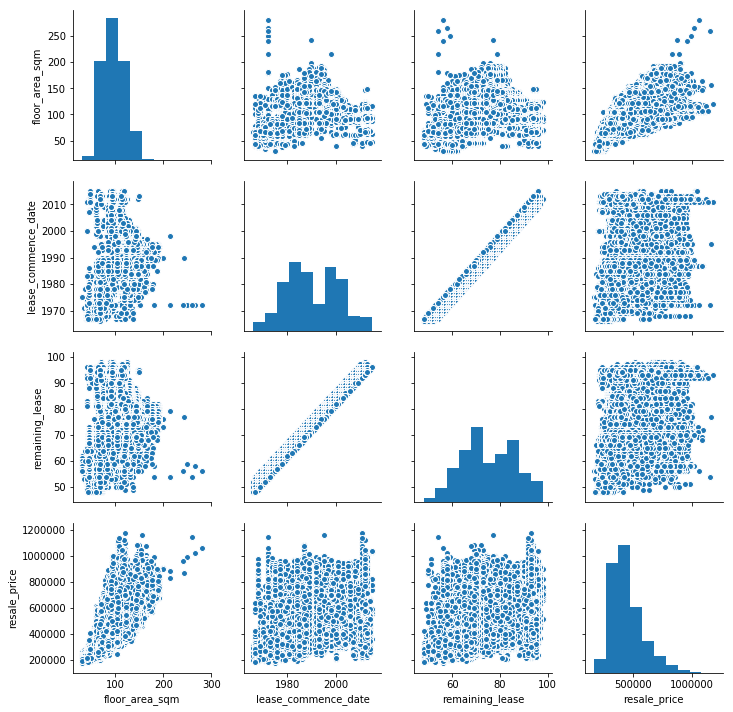

In [12]:
sns.pairplot(df)

## Features engineering

**Create new feature year**

In [13]:
# Create feature year

df["year"]=df["month"].apply(lambda x: x[0:4])
df["year"] = df["year"].astype(int)
df.iloc[:5][["month","year"]]

,month,year
0,2012-03,2012
1,2012-03,2012
2,2012-03,2012
3,2012-03,2012
4,2012-03,2012


**Create new feature storey_mean**

In [14]:
# The flat storeys are usually correlaed to the flat price - the higher it is, the more expensive the flat is.  
# We will add a new column get the mean storey from the storey_range

lower_storey_limit = df["storey_range"].str.slice(0,2).astype(int)
upper_storey_limit = df["storey_range"].str.slice(6,8).astype(int)
items = [1, 2, 3, 4, 5]
squared = list(map(lambda x: x**2, items))
df["storey_mean"] = list(map(lambda x,y: (x+y)/2, lower_storey_limit, upper_storey_limit))

**Create new feature addr**
This feature will be used to retrieve the latitude and longitude of the flat location and to compute the distance to the nearest MRT station.

In [15]:
# We will add a new column addr which concatenates the block and street_name data.

df["addr"]=df["block"] + " " + df["street_name"] + " SINGAPORE"

In [16]:
# We will update the addr to replace the shortform for Commonwealth

df["addr"]=df["addr"].str.replace("C'WEALTH","COMMONWEALTH")

**Create categorial codes for flat_type**

In [17]:
# Check the unique values of flat_type

df["flat_type"].value_counts()

4 ROOM              43216
3 ROOM              30088
5 ROOM              25136
EXECUTIVE            8515
2 ROOM               1134
1 ROOM                 64
MULTI-GENERATION       29
Name: flat_type, dtype: int64

In [18]:
# We will use label encoder to categorize the flat_type

#label_encoder = LabelEncoder()
#df["flat_cate"] = label_encoder.fit_transform(df["flat_type"])
df["flat_cate"] = df["flat_type"].map( {'1 ROOM':0,'2 ROOM':1,'3 ROOM':2,'4 ROOM':3,'5 ROOM':4,'EXECUTIVE':5,'MULTI-GENERATION':6}) 

In [19]:
df.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,storey_mean,addr,flat_cate
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,250000.0,2012,8.0,172 ANG MO KIO AVE 4 SINGAPORE,1
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,265000.0,2012,3.0,510 ANG MO KIO AVE 8 SINGAPORE,1
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,67,315000.0,2012,8.0,610 ANG MO KIO AVE 4 SINGAPORE,2


In [20]:
# Check on the correlation between variables

df.corr()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,year,storey_mean,flat_cate
floor_area_sqm,1.000000,0.417566,0.416606,0.684295,0.010635,0.046883,0.947096
lease_commence_date,0.417566,1.000000,0.982873,0.380796,0.099199,0.240440,0.464680
remaining_lease,0.416606,0.982873,1.000000,0.396008,-0.082497,0.226631,0.463526
resale_price,0.684295,0.380796,0.396008,1.000000,-0.082128,0.341524,0.687823
year,0.010635,0.099199,-0.082497,-0.082128,1.000000,0.071765,0.010778
storey_mean,0.046883,0.240440,0.226631,0.341524,0.071765,1.000000,0.090205
flat_cate,0.947096,0.464680,0.463526,0.687823,0.010778,0.090205,1.000000


**Create new feature distance_to_mrt (Mass Rapid Transist)**

Usually flats located near the MRT have higher resale value. To get the distance to the nearest MRT train station, we will ouput addr to a csv file and worked on the computation in a separate script (refer to distancetomrt.ipynb).

In [ ]:
# Output addr to addr.csv 
# Once distancetomrt.ipynb has computed the distance, we will just make use of the output csv to merge with df.

import csv

df_address = pd.DataFrame(data=df["addr"].unique(),columns=["addr"])

with open('addr.csv', 'w', encoding="utf-8", newline= "") as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["addr"])
    for i in range(len(df_address)):
        writer.writerow(df_address.iloc[i])

In [21]:
# distancetomrt.ipynb will compute distance to neart MRT station and output to distancetomrt.csv

file_distance = "distancetomrt.csv"
df_distance = pd.read_csv(os.path.join(path,file_distance))
df_distance.head(5)

,addr,coordinates,distance_to_mrt
0,172 ANG MO KIO AVE 4 SINGAPORE,"(1.3746617, 103.8366159)",0.355699
1,510 ANG MO KIO AVE 8 SINGAPORE,"(1.3734149, 103.8492068)",0.389115
2,610 ANG MO KIO AVE 4 SINGAPORE,"(1.3798478, 103.8394238)",0.649636
3,474 ANG MO KIO AVE 10 SINGAPORE,"(1.3628141, 103.8579939)",1.227196
4,604 ANG MO KIO AVE 5 SINGAPORE,"(1.37987235, 103.835974812884)",0.628509


In [22]:
# Merge df with df_distance to get distance_to_mrt

df_copy2 = df.copy()
df = pd.merge(df, df_distance, on='addr', how='left')
df.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,storey_mean,addr,flat_cate,coordinates,distance_to_mrt
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,250000.0,2012,8.0,172 ANG MO KIO AVE 4 SINGAPORE,1,"(1.3746617, 103.8366159)",0.355699
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,265000.0,2012,3.0,510 ANG MO KIO AVE 8 SINGAPORE,1,"(1.3734149, 103.8492068)",0.389115
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,67,315000.0,2012,8.0,610 ANG MO KIO AVE 4 SINGAPORE,2,"(1.3798478, 103.8394238)",0.649636


In [23]:
# Round distance off to 1 dec places

df["distance_to_mrt"]=df["distance_to_mrt"].apply(lambda x: round(x,1))

**Features selection**

In [24]:
# Scale down resale_price and present it in thousands

df["resale_price"]=df["resale_price"]/1000

In [25]:
# Drop columns which will not be used as features

df_final = df.drop(columns=["month","flat_type","block","street_name","storey_range","lease_commence_date","addr","coordinates"])

In [26]:
df_final.head(3)

,town,floor_area_sqm,flat_model,remaining_lease,resale_price,year,storey_mean,flat_cate,distance_to_mrt
0,ANG MO KIO,45.0,Improved,73,250.0,2012,8.0,1,0.4
1,ANG MO KIO,44.0,Improved,67,265.0,2012,3.0,1,0.4
2,ANG MO KIO,68.0,New Generation,67,315.0,2012,8.0,2,0.6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000213EE044278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000213EBA45B00>]], dtype=object)

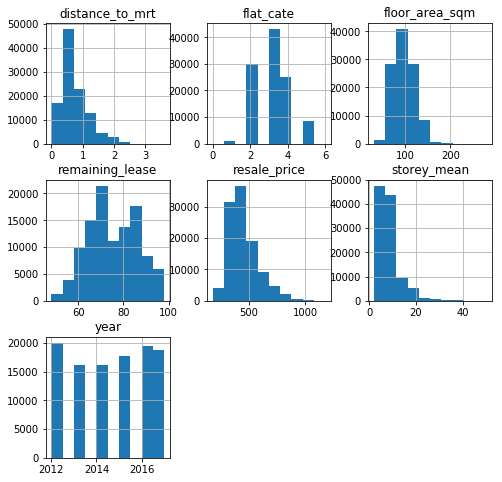

In [27]:
# Review the numerical data distribution

df_final.hist(figsize=(8,8))

In [28]:
# Create dummy variable for categorial features

df_final = pd.get_dummies(df_final, columns=["town","flat_model"])

In [29]:
df_final.head(3)

,floor_area_sqm,remaining_lease,resale_price,year,storey_mean,flat_cate,distance_to_mrt,town_ANG MO KIO,town_BEDOK,town_BISHAN,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,45.0,73,250.0,2012,8.0,1,0.4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44.0,67,265.0,2012,3.0,1,0.4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,67,315.0,2012,8.0,2,0.6,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [30]:
df_final.corr()

,floor_area_sqm,remaining_lease,resale_price,year,storey_mean,flat_cate,distance_to_mrt,town_ANG MO KIO,town_BEDOK,town_BISHAN,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
floor_area_sqm,1.000000,0.416606,0.684295,0.010635,0.046883,0.947096,0.094971,-0.134308,-0.098220,0.049043,...,0.041360,-0.355438,0.123591,0.015557,0.020417,-0.172774,-0.159919,0.016010,-0.003918,0.010365
remaining_lease,0.416606,1.000000,0.396008,-0.082497,0.226631,0.463526,0.112078,-0.178264,-0.177918,-0.019665,...,-0.003526,-0.382273,0.397460,0.013776,0.005383,-0.074920,-0.323668,-0.045317,0.070056,0.046038
resale_price,0.684295,0.396008,1.000000,-0.082128,0.341524,0.687823,-0.098964,-0.053621,-0.055825,0.161197,...,0.039470,-0.284397,0.072332,0.019168,0.019063,-0.150070,-0.049523,0.069595,0.129108,0.109765
year,0.010635,-0.082497,-0.082128,1.000000,0.071765,0.010778,0.013549,-0.002081,-0.006930,0.007991,...,-0.008474,-0.028563,0.033351,0.006277,-0.000742,-0.020199,-0.024576,-0.001111,0.027190,0.020475
storey_mean,0.046883,0.226631,0.341524,0.071765,1.000000,0.090205,0.010937,-0.009464,-0.027018,-0.003735,...,-0.005532,-0.124163,0.088646,0.012797,0.003067,-0.092294,-0.001036,-0.028447,0.140111,0.085251
flat_cate,0.947096,0.463526,0.687823,0.010778,0.090205,1.000000,0.090475,-0.147521,-0.095055,0.035451,...,0.051183,-0.369900,0.172233,0.007281,0.017644,-0.092817,-0.124740,-0.026741,-0.003900,0.026261
distance_to_mrt,0.094971,0.112078,-0.098964,0.013549,0.010937,0.090475,1.000000,-0.060971,-0.088277,-0.027027,...,-0.003434,-0.080459,0.100866,0.007799,-0.001438,-0.026944,-0.058919,0.006947,-0.026358,-0.017990
town_ANG MO KIO,-0.134308,-0.178264,-0.053621,-0.002081,-0.009464,-0.147521,-0.060971,1.000000,-0.059250,-0.031246,...,-0.003707,0.367044,-0.073306,-0.001686,-0.001947,-0.054275,-0.037061,-0.005636,-0.009165,-0.006082
town_BEDOK,-0.098220,-0.177918,-0.055825,-0.006930,-0.027018,-0.095055,-0.088277,-0.059250,1.000000,-0.036117,...,-0.004285,0.203503,-0.053695,-0.001949,-0.002251,-0.010125,0.004149,-0.006515,-0.010594,-0.007030
town_BISHAN,0.049043,-0.019665,0.161197,0.007991,-0.003735,0.035451,-0.027027,-0.031246,-0.036117,1.000000,...,0.026925,-0.046135,-0.023724,-0.001028,-0.001187,0.112340,-0.026664,-0.003436,-0.005587,-0.003707


In [31]:
df_final.columns

Index(['floor_area_sqm', 'remaining_lease', 'resale_price', 'year',
       'storey_mean', 'flat_cate', 'distance_to_mrt', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_2-room', 'flat_model_Adjoined flat', 'flat_model_Apartment',
       'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Improved-Maisonette', 'flat_model_Maisonette',
       'flat_model_Model A', 'flat_model_Model A-Maisonette',
       'flat_model_Model A2', 'flat_model_Multi Generation',
       'flat_model_New Genera

## Split into train and test set

In [32]:
# Split train and test set. As flat_cate has high correlation to resale_price, we try to ensure the train and test set has equal representation of flat_cate rec

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=8)
for train_index, test_index in split.split(df_final, df_final["flat_cate"]):
    strat_train_set = df_final.loc[train_index]
    strat_test_set = df_final.loc[test_index]

In [33]:
strat_train_set.columns

Index(['floor_area_sqm', 'remaining_lease', 'resale_price', 'year',
       'storey_mean', 'flat_cate', 'distance_to_mrt', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_2-room', 'flat_model_Adjoined flat', 'flat_model_Apartment',
       'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Improved-Maisonette', 'flat_model_Maisonette',
       'flat_model_Model A', 'flat_model_Model A-Maisonette',
       'flat_model_Model A2', 'flat_model_Multi Generation',
       'flat_model_New Genera

In [34]:
# Get the last column name of the town dummy variable. To drop from train data to prevent dummy variable trap

town = strat_train_set.columns[strat_train_set.columns.str.contains('town')][-1]
town

'town_YISHUN'

In [35]:
# Get the last column name of the flat_model dummy variable. To drop from train data to prevent dummy variable trap

fmodel = strat_train_set.columns[strat_train_set.columns.str.contains('flat_model')][-1]
fmodel

'flat_model_Type S2'

In [37]:
# Set the train data and target

X = strat_train_set.drop(columns=["resale_price","flat_cate", town, fmodel], axis=1)
y = strat_train_set[["resale_price"]]

**Feature Scaling**

In [38]:
# Scale X.  Since there are outliers in the data, we will use RobustScaler

from sklearn.preprocessing import RobustScaler

scale_x = RobustScaler()
train_x = scale_x.fit_transform(X)

## Modelling and model evaluation

In [39]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

C:\Users\stephielsw\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
# Create classifier objects. 

k_fold = KFold(n_splits=5,random_state = 8, shuffle=True)

LR = LinearRegression()
RFR = RandomForestRegressor(random_state=8)
SVL = SVR(kernel = 'linear')
XG = xgb.XGBRegressor()


#clf_list = {"clf": [LR, RFR, XG], "desc": ["LinearRegression", "RandomForestRegression","XGBoost"]}
clf_list = {"clf": [LR, RFR, SVL, XG], "desc": ["LinearRegression", "RandomForestRegression","SupportVectRegression(linear)","XGBoost"]}

In [41]:
# Run cross validation and evaluate using RMSE and R2

from sklearn.model_selection import cross_val_score

def run_cvs_mse(X, y, kfold, clf_class):
    scores = cross_val_score(clf_class, X, y,scoring="neg_mean_squared_error", cv=kfold)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

def run_cvs_r2(X, y, kfold, clf_class):
    scores = cross_val_score(clf_class, X, y,scoring="r2", cv=kfold)
    return scores


score_dict={}
for i in range(len(clf_list["clf"])):
    print(clf_list["desc"][i],"-scoring started")
    if clf_list["desc"][i] != "SupportVectRegression(rbf)" and clf_list["desc"][i] != "SupportVectRegression(linear)" :
        rmse_score = run_cvs_mse(X,np.array(y).ravel(),k_fold, clf_list["clf"][i])
        r2_score = run_cvs_r2(X,np.array(y).ravel(),k_fold, clf_list["clf"][i])
    else:
        rmse_score = run_cvs_mse(train_x,np.array(y).ravel(),k_fold, clf_list["clf"][i])
        r2_score = run_cvs_r2(train_x,np.array(y).ravel(),k_fold, clf_list["clf"][i])
        
    rmse_mean = round(rmse_score.mean(),3)
    rmse_std = round(rmse_score.std(),3)
    r2_mean = round(r2_score.mean(),4)
    r2_std = round(r2_score.std(),4)

    #print(rmse_mean, rmse_std, r2_mean, r2_std)
    if "classifier" in score_dict.keys():
        score_dict["classifier"].append(clf_list["desc"][i])
        score_dict["rmse_score"].append(rmse_score)
        score_dict["rmse_mean"].append(rmse_mean)
        score_dict["rmse_std"].append(rmse_std)
        score_dict["r2_score"].append(r2_score)
        score_dict["r2_mean"].append(r2_mean)
        score_dict["r2_std"].append(r2_std)
    else:
        score_dict["classifier"] = [clf_list["desc"][i]]
        score_dict["rmse_score"] = [rmse_score]
        score_dict["rmse_mean"]= [rmse_mean]
        score_dict["rmse_std"]=[rmse_std]
        score_dict["r2_score"] = [r2_score]
        score_dict["r2_mean"]=[r2_mean]
        score_dict["r2_std"]=[r2_std]
        
    print(clf_list["desc"][i],"-scoring completed")

LinearRegression -scoring started
LinearRegression -scoring completed
RandomForestRegression -scoring started
RandomForestRegression -scoring completed
SupportVectRegression(linear) -scoring started
SupportVectRegression(linear) -scoring completed
XGBoost -scoring started
XGBoost -scoring completed


In [42]:
df_score=pd.DataFrame(score_dict,columns=["classifier","rmse_score","rmse_mean","rmse_std","r2_score","r2_mean","r2_std"])
df_score

,classifier,rmse_score,rmse_mean,rmse_std,r2_score,r2_mean,r2_std
0,LinearRegression,"[48.0098545063, 48.7465066581, 48.2188446097, ...",48.177,0.321,"[0.867745726577, 0.866542010035, 0.86751509582...",0.8678,0.0010
1,RandomForestRegression,"[28.6923069752, 28.2971668816, 28.9230437674, ...",28.697,0.294,"[0.952763265004, 0.955027866062, 0.95233267445...",0.9531,0.0015
2,SupportVectRegression(linear),"[50.7455939414, 51.5906922331, 50.7103043319, ...",50.912,0.453,"[0.852243833736, 0.850514078247, 0.85347044521...",0.8524,0.0011
3,XGBoost,"[45.8201027464, 46.9738840461, 46.5525862539, ...",46.200,0.483,"[0.879534953759, 0.876071690328, 0.87651323226...",0.8784,0.0023


## Hyperparameters tuning
Based on rmse_mean and r2_mean, RandomForestRegressor seems to be the best model. We will fine-tune the hyperparameters with GridSearch

In [43]:
from sklearn.model_selection import GridSearchCV

def run_grid(X, y, kfold, clf_class, param):
    grid_search = GridSearchCV(estimator = clf_class, param_grid = param, scoring = 'neg_mean_squared_error',cv = kfold, )
    grid_search = grid_search.fit(X,y)
    return [grid_search.best_score_, grid_search.best_params_,grid_search.best_estimator_]


RFR_param = [{'n_estimators': [200,220, 240]}]

grid_result=[]
grid_result.append(run_grid(X, np.array(y).ravel(), k_fold, RFR, RFR_param))
grid_result

[[-746.50180844451427,
  {'n_estimators': 240},
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=1,
             oob_score=False, random_state=8, verbose=0, warm_start=False)]]

## Prediction

In [44]:
# Set the test data and target

Xt = strat_test_set.drop(columns=["resale_price","flat_cate",town, fmodel], axis=1)
yt = strat_test_set[["resale_price"]]

#test_x = scale_x.transform(Xt)

In [45]:
# Make prediction with the final model

final_model=grid_result[0][2]
y_pred = final_model.predict(Xt)

In [48]:
# Output results on the predicted and true value of resale_price for test data into resale_price_prediction_result.csv

import csv
        
df_result=yt.copy()
df_result.rename(columns={"resale_price":"true_y"},inplace=True)
df_result["pred_y"]=y_pred
df_result["diff"]=df_result["pred_y"]-df_result["true_y"]
df_result["index"] = df_result.index.values

with open('resale_price_prediction_result.csv', 'w', encoding="utf-8", newline= "") as csvfile: 
    writer = csv.writer(csvfile, delimiter=',') 
    writer.writerow(["true_y","pred_y","diff","index"]) 
    for i in range(len(df_result)): 
        writer.writerow(df_result.iloc[i])

In [49]:
# Evaluate the test data results

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

final_mse = mean_squared_error(yt, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 =r2_score(yt, y_pred)

In [50]:
print("Root mean squared error for test data:",final_rmse)
print("R2 for test data:", final_r2)

Root mean squared error for test data: 26.183240808
R2 for test data: 0.961201905659


**With our Random Forest Regression model, we obtain a root mean square error of about $26000 and r2 with a score close to 1**